## Importing Data

In [1]:
import pandas as pd
Data = pd.read_excel("Online Retail.xlsx")
Data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
#changing CustomerID data type
Data = Data.astype({'CustomerID': 'Int64'})
Data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [3]:
#Formatting Date/Time
Data['InvoiceDate'] = pd.to_datetime(Data['InvoiceDate'], format = '%m/%d/%Y %H:%M')

#formatting Strings and removing whitespace characters
Data['Description'] = Data['Description'].str.replace('.','').str.upper().str.strip()
Data['Description'] = Data['Description'].replace('\s+',' ',regex = True)
Data['InvoiceNo'] = Data['InvoiceNo'].astype(str).str.upper()
Data['StockCode'] = Data['StockCode'].astype(str).str.upper()
Data['Country'] = Data['Country'].str.upper()
Data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,UNITED KINGDOM
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,UNITED KINGDOM
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,UNITED KINGDOM
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,UNITED KINGDOM
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART,6,2010-12-01 08:26:00,3.39,17850,UNITED KINGDOM


## Data Preprocessing

### Irregular values

In [4]:
#Listing Some Irrelevant StockCodes
odd_stock = Data['StockCode'].unique()
odd_stock.sort()
print('Irrelevant Transactions: \n',odd_stock[::-1][:4])
#Quantity and UnitPrice Summary
Data.describe().iloc[:,:2]


Irrelevant Transactions: 
 ['S' 'POST' 'PADS' 'M']


,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [5]:
#Outliers and Irrelevant Values
#Dropping all stockcodes that contain only strings
import numpy as np, re, scipy as sp, scipy.stats
CodeTypes = list(map(lambda codes: any(char.isdigit() for char in codes), Data['StockCode']))
IrrelevantCodes = [i for i,v in enumerate(CodeTypes) if v == False]
Data.drop(IrrelevantCodes , inplace = True)
#Removing Outliers Based on Z-score (indicates a value that how much standard deviation is away from the mean)
Data = Data[(np.abs(sp.stats.zscore(Data['UnitPrice']))<3) & (np.abs(sp.stats.zscore(Data['Quantity']))<5)]

### Checking for Null values

In [6]:
Data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1443
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     131346
Country             0
dtype: int64

In [7]:
# Missing & Incorrect Values
# InvoiceNo with c in the beginning shows the product that was returned 
Data.drop(Data[(Data.Quantity>0) & (Data.InvoiceNo.str.contains('C') == True)].index, inplace = True)
Data.drop(Data[(Data.Quantity<0) & (Data.InvoiceNo.str.contains('C') == False)].index, inplace = True)
# incorrect description
Data.drop(Data[Data.Description.str.contains('?',regex=False) == True].index, inplace = True)
# incorrect price
Data.drop(Data[Data.UnitPrice == 0].index, inplace = True)

# looping through the null values in Description
for index,value in Data.StockCode[Data.Description.isna()==True].items():
    # check is the descriptions for same stockCodes is not null 
    if pd.notna(Data.Description[Data.StockCode == value]).sum() != 0:
        # replace null value with the mode of the descriptions from that stockCode
        Data.Description[index] = Data.Description[Data.StockCode == value].mode()[0]
    else:
        Data.drop(index = index, inplace = True)
        
Data['Description'] = Data['Description'].astype(str)

In [8]:
#Incorrect Prices
StockList = Data.StockCode.unique()
CalculatedMode = map(lambda x: Data.UnitPrice[Data.StockCode == x].mode()[0],StockList)
StockModes = list(CalculatedMode)
for i,v in enumerate(StockList):
    Data.loc[Data['StockCode']== v, 'UnitPrice'] = StockModes[i]

In [9]:
#Customers with Different Countries
Customers = Data.groupby('CustomerID')['Country'].unique()
Customers.loc[Customers.apply(lambda x:len(x)>1)]

CustomerID
12370           [CYPRUS, AUSTRIA]
12394          [BELGIUM, DENMARK]
12417            [BELGIUM, SPAIN]
12422    [AUSTRALIA, SWITZERLAND]
12429          [DENMARK, AUSTRIA]
12431        [AUSTRALIA, BELGIUM]
12455             [CYPRUS, SPAIN]
12457       [SWITZERLAND, CYPRUS]
Name: Country, dtype: object

In [10]:
#Fixing Duplicate CustomerIDs
for i,v in Data.groupby('CustomerID')['Country'].unique().items():
    if len(v)>1:
        Data.Country[Data['CustomerID'] == i] = Data.Country[Data['CustomerID'] == i].mode()[0]

#Adding Desired Features
Data['FinalPrice'] = Data['Quantity']*Data['UnitPrice']
Data['InvoiceMonth'] = Data['InvoiceDate'].apply(lambda x: x.strftime('%B'))
Data['Day of week'] = Data['InvoiceDate'].dt.day_name()

Data['Year'] = Data['InvoiceDate'].dt.year
# dropping remaining null values
Data = Data.dropna()
#Exporting Processed Data
Data.to_csv(r'OnlineRetail_Cleaned.csv', date_format = '%Y-%m-%d %H:%M', index = False)
Data.head()

<ipython-input-10-b48c391b1b0b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data.Country[Data['CustomerID'] == i] = Data.Country[Data['CustomerID'] == i].mode()[0]
<ipython-input-10-b48c391b1b0b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data.Country[Data['CustomerID'] == i] = Data.Country[Data['CustomerID'] == i].mode()[0]
<ipython-input-10-b48c391b1b0b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data.Country[Data['C

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,FinalPrice,InvoiceMonth,Day of week,Year
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.95,17850,UNITED KINGDOM,17.7,December,Wednesday,2010
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.75,17850,UNITED KINGDOM,22.5,December,Wednesday,2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,4.15,17850,UNITED KINGDOM,33.2,December,Wednesday,2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.75,17850,UNITED KINGDOM,22.5,December,Wednesday,2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART,6,2010-12-01 08:26:00,4.25,17850,UNITED KINGDOM,25.5,December,Wednesday,2010


## Data Visualization 

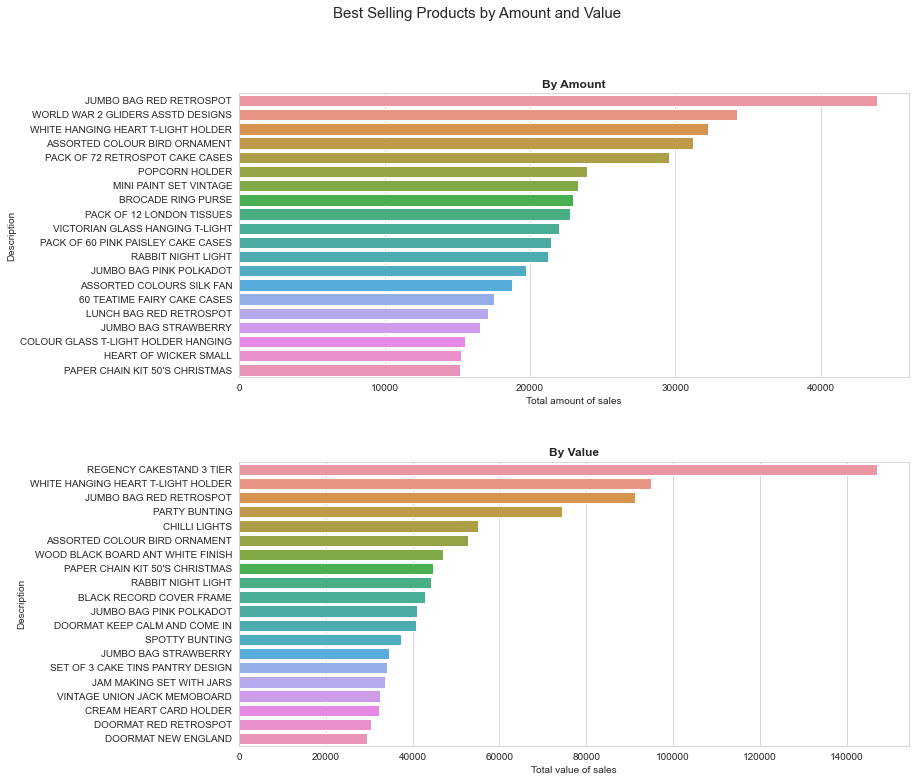

In [11]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

%matplotlib inline
CleanDataset = r'OnlineRetail_Cleaned.csv'
Data_Cleaned = pd.read_csv(CleanDataset, index_col = 'InvoiceDate')
Data_Cleaned.index = pd.to_datetime(Data_Cleaned.index, format = '%Y-%m-%d %H:%M')

#top 20 products by quantity and finalprice
sns.set_style('whitegrid')
Top20Quan = Data_Cleaned.groupby('Description')['Quantity'].agg('sum').sort_values(ascending=False)[0:20]
Top20Price = Data_Cleaned.groupby('Description')['FinalPrice'].agg('sum').sort_values(ascending=False)[0:20]

#creating the subplot
fig,axs = plt.subplots(nrows=2, ncols=1, figsize = (12,12))
plt.subplots_adjust(hspace = 0.3)
fig.suptitle('Best Selling Products by Amount and Value', fontsize=15, x = 0.4, y = 0.98)

sns.barplot(x=Top20Quan.values, y=Top20Quan.index, ax= axs[0]).set(xlabel='Total amount of sales')
axs[0].set_title('By Amount', size=12, fontweight = 'bold')

sns.barplot(x=Top20Price.values, y=Top20Price.index, ax= axs[1]).set(xlabel='Total value of sales')
axs[1].set_title('By Value', size=12, fontweight = 'bold')
plt.show()

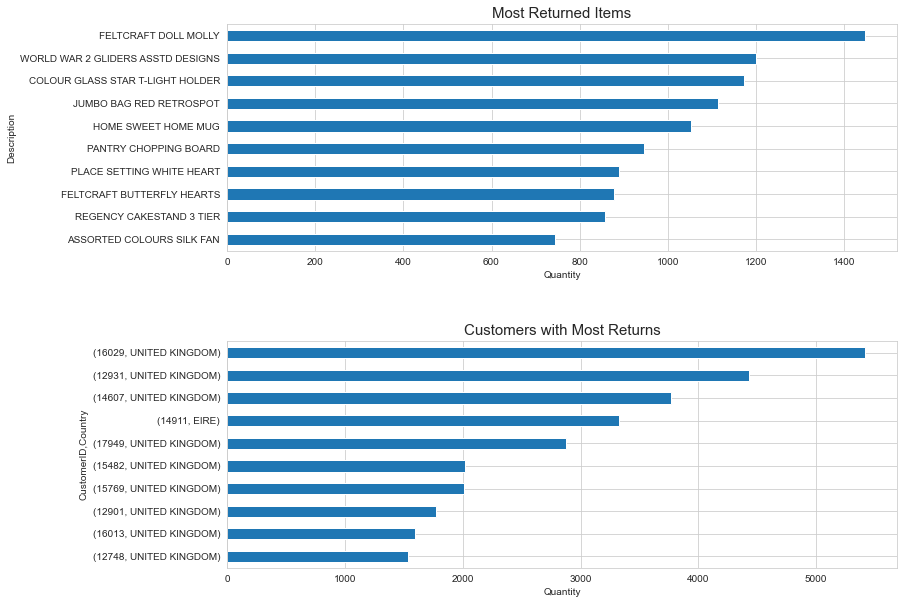

In [12]:
#finding the most returned items and the customers with the corresponding country
ReturnedItems = Data_Cleaned[Data_Cleaned.Quantity<0].groupby('Description')['Quantity'].sum()
ReturnedItems = ReturnedItems.abs().sort_values(ascending=False)[0:10]
ReturnCust = Data_Cleaned[Data_Cleaned.Quantity<0].groupby(['CustomerID','Country'])['Quantity'].sum()
ReturnCust = ReturnCust.abs().sort_values(ascending=False)[0:10]
#creting the subplot
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(12,10))
ReturnedItems.sort_values().plot(kind='barh', ax=ax1).set_title('Most Returned Items', fontsize=15)
ReturnCust.sort_values().plot(kind='barh', ax=ax2).set_title('Customers with Most Returns', fontsize=15)
ax1.set(xlabel='Quantity')
ax2.set(xlabel='Quantity')
plt.subplots_adjust(hspace=0.4)
plt.show()

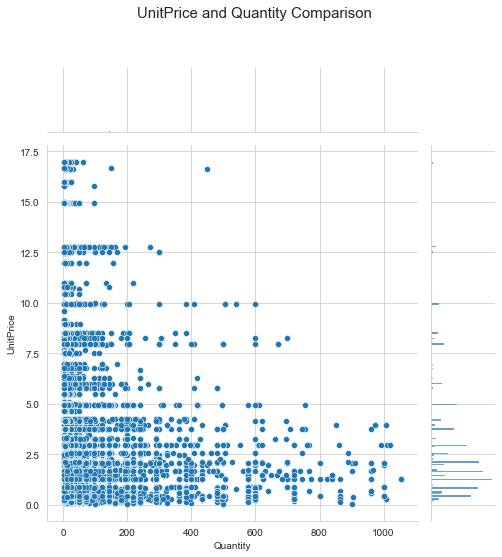

In [13]:
#plotting the qunatity vs unitprice
Corr = sns.jointplot(x="Quantity", y="UnitPrice", data = Data_Cleaned[Data_Cleaned.FinalPrice>0], height = 7)
Corr.fig.suptitle("UnitPrice and Quantity Comparison", fontsize = 15, y = 1.1)
plt.show()

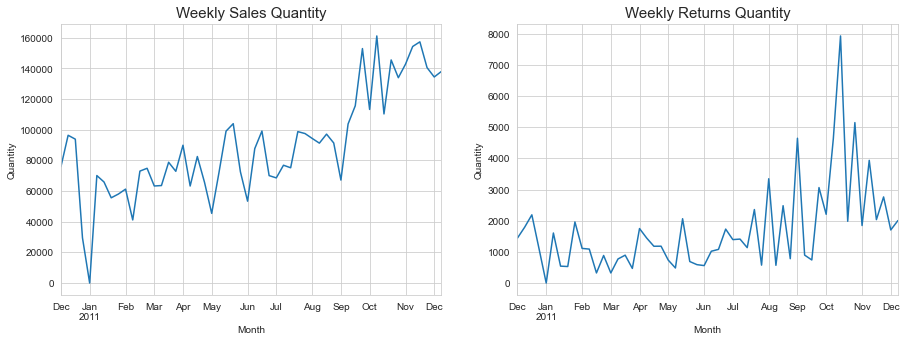

In [14]:
#resampling to get the weekly sales and returns
WeeklySale = Data_Cleaned[Data_Cleaned['Quantity']>0].Quantity.resample('W').sum()
WeeklyRet = Data_Cleaned[Data_Cleaned['Quantity']<0].Quantity.resample('W').sum().abs()
#creating the subplot
fig,[ax1, ax2] = plt.subplots(nrows=1,ncols=2, figsize = (15,5))
WeeklySale.plot(ax=ax1).set(xlabel="Month", ylabel="Quantity")
ax1.set_title("Weekly Sales Quantity", fontsize = 15)
WeeklyRet.plot(ax=ax2).set(xlabel="Month", ylabel="Quantity")
ax2.set_title("Weekly Returns Quantity", fontsize = 15)
plt.show()

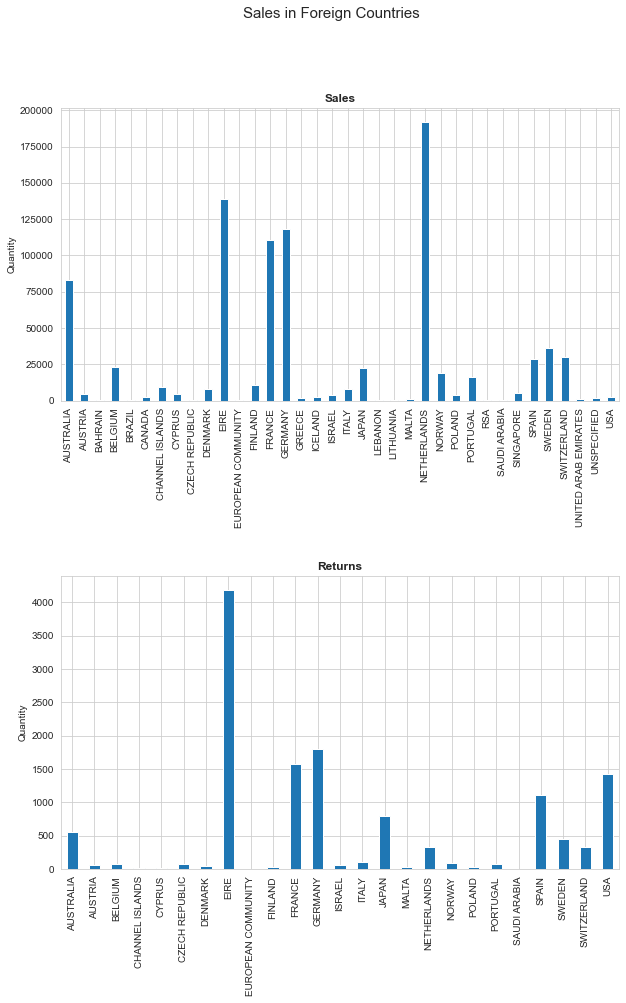

In [15]:
#grouping data by the countries(except UK)
ByCountrySale = Data_Cleaned[(Data_Cleaned.Country != 'UNITED KINGDOM') & (Data_Cleaned.Quantity > 0)].groupby('Country')['Quantity'].sum()
ByCountryRet = Data_Cleaned[(Data_Cleaned.Country != 'UNITED KINGDOM') & (Data_Cleaned.Quantity < 0)].groupby('Country')['Quantity'].sum().abs()
#creating the subplot
fig, [ax1,ax2] = plt.subplots(nrows=2,ncols=1,figsize=(10,14))
ByCountrySale.plot(kind='bar', ax=ax1).set(ylabel = 'Quantity',xlabel='')
ax1.set_title('Sales', size=12, fontweight = 'bold')
ByCountryRet.plot(kind='bar', ax=ax2).set(ylabel = 'Quantity',xlabel='')
ax2.set_title('Returns', size=12, fontweight = 'bold')
plt.suptitle('Sales in Foreign Countries', fontsize = 15)
plt.subplots_adjust(hspace = 0.6)
plt.show()

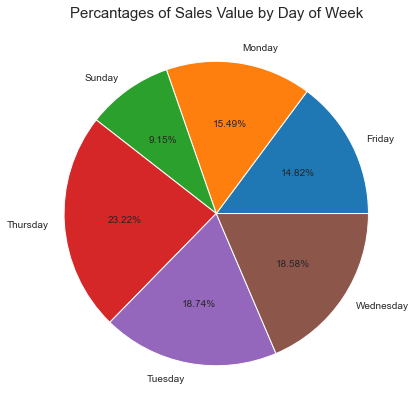

In [16]:
#creating the pie chart
Data_Cleaned.groupby('Day of week')['FinalPrice'].sum().plot(kind = 'pie', autopct = '%.2f%%', figsize=(7,7)).set(ylabel='')
plt.title('Percantages of Sales Value by Day of Week', fontsize = 15)
plt.show()

In [17]:
Data_Cleaned.isnull().sum()

InvoiceNo       0
StockCode       0
Description     0
Quantity        0
UnitPrice       0
CustomerID      0
Country         0
FinalPrice      0
InvoiceMonth    0
Day of week     0
Year            0
dtype: int64

C:\Users\Chitra S. Lakhani\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Chitra S. Lakhani\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


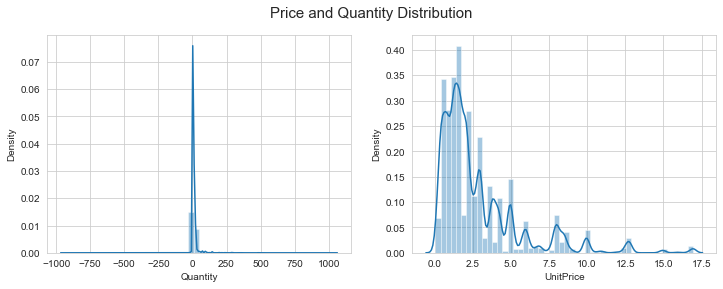

In [18]:
#creating distribution plots
fig , [ax1,ax2] = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
with sns.axes_style('dark'):
    sns.distplot(Data_Cleaned['Quantity'], ax=ax1)
    sns.distplot(Data_Cleaned['UnitPrice'], ax=ax2)
fig.suptitle('Price and Quantity Distribution', fontsize = 15)
plt.show()

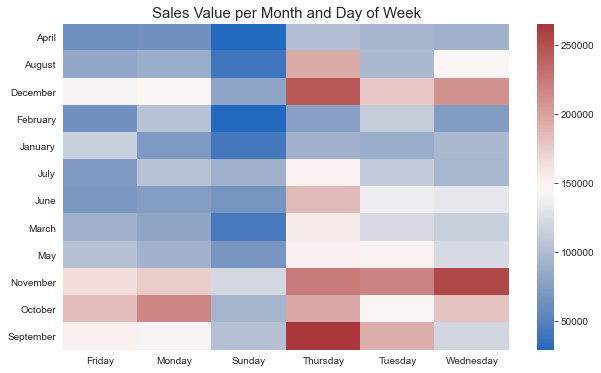

In [19]:
HM_Data = Data_Cleaned.pivot_table(index = 'InvoiceMonth',columns = 'Day of week', values = 'FinalPrice', aggfunc='sum')
plt.figure(figsize = (10,6))
sns.heatmap(HM_Data, cmap = 'vlag').set(xlabel='', ylabel='')
plt.title('Sales Value per Month and Day of Week', fontsize = 15)
plt.show()

In [20]:
Data_Cleaned.isnull().sum()

InvoiceNo       0
StockCode       0
Description     0
Quantity        0
UnitPrice       0
CustomerID      0
Country         0
FinalPrice      0
InvoiceMonth    0
Day of week     0
Year            0
dtype: int64

In [21]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import chart_studio.plotly as py, plotly.graph_objs as go
import cufflinks as cf
import pycountry
from pycountry_convert import country_name_to_country_alpha3
init_notebook_mode(connected=True)
%matplotlib inline

#importing dataset
CleanDataset = r'OnlineRetail_Cleaned.csv'
Data_Cleaned = pd.read_csv(CleanDataset, index_col = 'InvoiceDate')
Data_Cleaned.index = pd.to_datetime(Data_Cleaned.index, format = '%Y-%m-%d %H:%M')

#function to get country codes from country names
def code(x):
    try:
        return country_name_to_country_alpha3(x,cn_name_format='upper')
    except:
        pass
Data_Cleaned['CountryCode'] = Data_Cleaned['Country'].map(code)

#creating the choropleth map
mapdata = Data_Cleaned.dropna()
map_data = {
    'type': 'choropleth',
    'autocolorscale' : False,
    'colorscale' : 'Portland',
    'locations' : mapdata[mapdata['CountryCode']!='GBR'].groupby('CountryCode', sort=False)['FinalPrice'].sum().index,
    'z' : mapdata[mapdata['CountryCode']!='GBR'].groupby('CountryCode', sort=False)['FinalPrice'].sum().values,
    'text' :  mapdata[mapdata['CountryCode']!='GBR']['Country'].unique(),
    'colorbar' : {'title':'Pounds'}
}
map_layout = {
    'title' : 'Sales in Foreign Countries',
    'geo' : {'showframe' : False, 'projection' : {'type':'equirectangular'}}
}
FinalMap = go.Figure(data = [map_data], layout = map_layout)
iplot(FinalMap)


## Linear Regression

In [22]:
# adding information required
dfs = Data
dfs['revenue'] = dfs['UnitPrice']*dfs['Quantity']
operations = {'revenue':'sum',
              'Quantity':'sum',
              'InvoiceDate':'first',
              'CustomerID':'first' 
             }

dfs = dfs.groupby('InvoiceNo').agg(operations)
dfs['year'] = dfs['InvoiceDate'].apply(lambda x: x.year)
dfs['days_since'] = (pd.datetime(year=2010, month=12, day=31) - 
                    dfs['InvoiceDate']).apply(lambda x: x.days)
dfs.head()

<ipython-input-22-007707113d3e>:12: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



,revenue,Quantity,InvoiceDate,CustomerID,year,days_since
InvoiceNo,,,,,,
536365,168.10,40,2010-12-01 08:26:00,17850,2010,29
536366,25.20,12,2010-12-01 08:28:00,17850,2010,29
536367,289.81,83,2010-12-01 08:34:00,13047,2010,29
536368,70.05,15,2010-12-01 08:34:00,13047,2010,29
536369,17.85,3,2010-12-01 08:35:00,13047,2010,29


In [23]:
operations = {'revenue':'sum',
              'Quantity':'sum',
              'days_since':['max','min','nunique'],
             }

X = dfs[dfs['year'] == 2010].groupby('CustomerID').agg(operations)
X.head()

revenue Quantity days_since            
                sum      sum        max min nunique
CustomerID                                         
12347        822.19      319         23  23       1
12348        715.20     1248         14  14       1
12370       1776.35      965         16  13       2
12377        981.68      604         10  10       1
12383        557.56      751          8   8       1

In [25]:
X.columns = [' '.join(col).strip() for col in X.columns.values]
X.head()

,revenue sum,Quantity sum,days_since max,days_since min,days_since nunique
CustomerID,,,,,
12347,822.19,319,23,23,1
12348,715.20,1248,14,14,1
12370,1776.35,965,16,13,2
12377,981.68,604,10,10,1
12383,557.56,751,8,8,1


In [27]:
X['avg_order_cost'] = X['revenue sum']/X['days_since nunique']
X.head()

,revenue sum,Quantity sum,days_since max,days_since min,days_since nunique,avg_order_cost
CustomerID,,,,,,
12347,822.19,319,23,23,1,822.190
12348,715.20,1248,14,14,1,715.200
12370,1776.35,965,16,13,2,888.175
12377,981.68,604,10,10,1,981.680
12383,557.56,751,8,8,1,557.560


In [29]:
operations = {'revenue':'sum',
              'Quantity':'sum'
             }
y = dfs[dfs['year'] == 2011].groupby('CustomerID').agg(operations)
y

,revenue,Quantity
CustomerID,,
12347,3804.19,2139
12348,784.44,1084
12349,1411.00,629
12350,321.16,196
12352,1269.55,463
...,...,...
18280,180.75,45
18281,80.82,54
18282,151.16,98


In [30]:
wrangled_df = pd.concat([X,y], axis=1)
wrangled_df.columns = ['2010 revenue',
                       '2010 Total Quantity',
                       'days_since_first_purchase',
                       'days_since_last_purchase',
                       'number_of_purchases',
                       'avg_order_cost',
                       '2011 revenue',
                       '2011 Total Quantity']
wrangled_df.head()

,2010 revenue,2010 Total Quantity,days_since_first_purchase,days_since_last_purchase,number_of_purchases,avg_order_cost,2011 revenue,2011 Total Quantity
12347,822.19,319.0,23.0,23.0,1.0,822.190,3804.19,2139.0
12348,715.20,1248.0,14.0,14.0,1.0,715.200,784.44,1084.0
12370,1776.35,965.0,16.0,13.0,2.0,888.175,1743.53,1385.0
12377,981.68,604.0,10.0,10.0,1.0,981.680,522.06,338.0
12383,557.56,751.0,8.0,8.0,1.0,557.560,1106.51,764.0


In [31]:
wrangled_df = wrangled_df[~wrangled_df['2010 revenue'].isnull()]
wrangled_df = wrangled_df[~wrangled_df['2011 revenue'].isnull()]
wrangled_df.head()

,2010 revenue,2010 Total Quantity,days_since_first_purchase,days_since_last_purchase,number_of_purchases,avg_order_cost,2011 revenue,2011 Total Quantity
12347,822.19,319.0,23.0,23.0,1.0,822.190,3804.19,2139.0
12348,715.20,1248.0,14.0,14.0,1.0,715.200,784.44,1084.0
12370,1776.35,965.0,16.0,13.0,2.0,888.175,1743.53,1385.0
12377,981.68,604.0,10.0,10.0,1.0,981.680,522.06,338.0
12383,557.56,751.0,8.0,8.0,1.0,557.560,1106.51,764.0


In [32]:
wrangled_df = wrangled_df[wrangled_df['2011 revenue'] 
                          < ((wrangled_df['2011 revenue'].median()) 
                             + wrangled_df['2011 revenue'].std()*3)]
wrangled_df = wrangled_df[wrangled_df['2010 revenue'] 
                          < ((wrangled_df['2010 revenue'].median()) 
                             + wrangled_df['2010 revenue'].std()*3)] 
wrangled_df.head()
wrangled_df.index.name = 'Customer ID'

In [33]:
wrangled_df.to_csv('wrangled_transactions.csv')

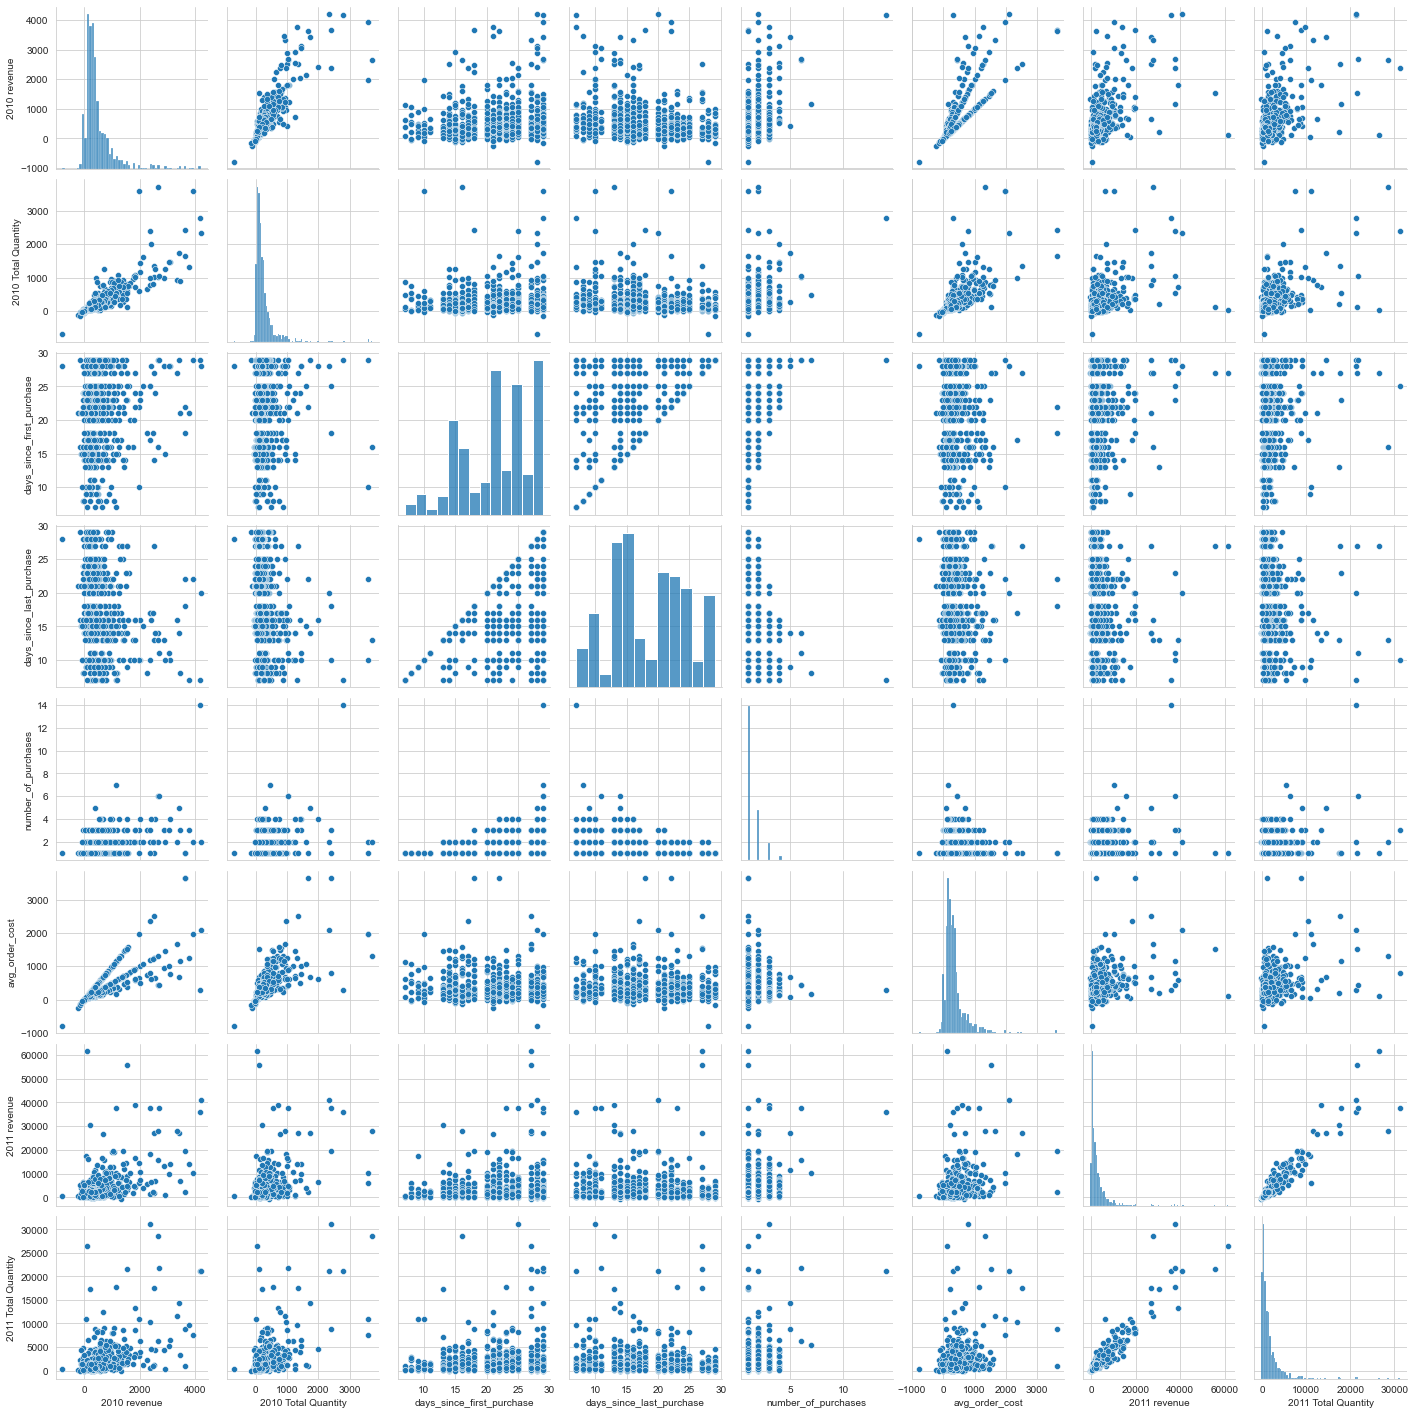

In [34]:
df = pd.read_csv('wrangled_transactions.csv', index_col='Customer ID')

import seaborn as sns
%matplotlib inline

sns.pairplot(df)

In [35]:
df.corr()

,2010 revenue,2010 Total Quantity,days_since_first_purchase,days_since_last_purchase,number_of_purchases,avg_order_cost,2011 revenue,2011 Total Quantity
2010 revenue,1.000000,0.846525,0.110272,-0.240922,0.479560,0.786683,0.546438,0.552993
2010 Total Quantity,0.846525,1.000000,0.045261,-0.205640,0.378389,0.699869,0.465500,0.587306
days_since_first_purchase,0.110272,0.045261,1.000000,0.592975,0.301941,-0.063132,0.095227,0.059513
days_since_last_purchase,-0.240922,-0.205640,0.592975,1.000000,-0.419338,-0.045472,-0.118062,-0.145295
number_of_purchases,0.479560,0.378389,0.301941,-0.419338,1.000000,-0.017380,0.328412,0.331486
avg_order_cost,0.786683,0.699869,-0.063132,-0.045472,-0.017380,1.000000,0.386524,0.390956
2011 revenue,0.546438,0.465500,0.095227,-0.118062,0.328412,0.386524,1.000000,0.937472
2011 Total Quantity,0.552993,0.587306,0.059513,-0.145295,0.331486,0.390956,0.937472,1.000000


In [36]:
X = df[['2010 revenue',
        '2010 Total Quantity',
       'days_since_last_purchase',
       'number_of_purchases',
       'avg_order_cost'
       ]]
y = df[['2011 revenue', '2011 Total Quantity']]

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 100)

In [38]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [39]:
model.coef_

array([[ 5.03048731e+00,  5.00470341e-01,  6.16659264e+01,
         6.07086042e+02, -8.33044171e-01],
       [ 1.01429435e+00,  3.63691351e+00,  2.05968914e+01,
         3.17659294e+02, -4.70873025e-01]])

In [40]:
model.intercept_

array([-1188.71541447,  -371.1269911 ])

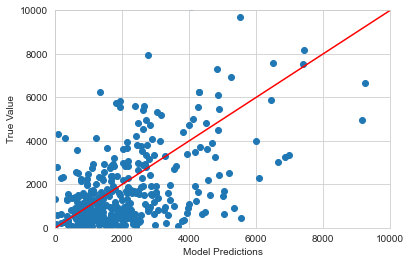

In [41]:
%matplotlib inline

plt.scatter(model.predict(X_test),y_test)
plt.xlim(0,10000)
plt.ylim(0,10000)
plt.plot([0, 10000], [0, 10000], 'k-', color = 'r')
plt.xlabel('Model Predictions')
plt.ylabel('True Value')
plt.show()

## Multi-task regression using PyTorch

C:\Users\Chitra S. Lakhani\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning:

Using a target size (torch.Size([])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Time taken for training 50 epochs: 83.37530565261841


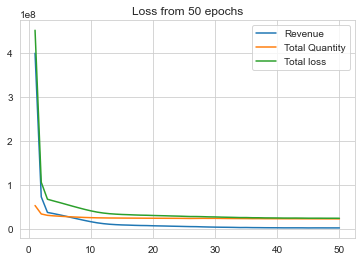

Validation Loss: 6929607161389.204


C:\Users\Chitra S. Lakhani\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning:

Using a target size (torch.Size([])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Time taken for training 60 epochs: 113.43889164924622


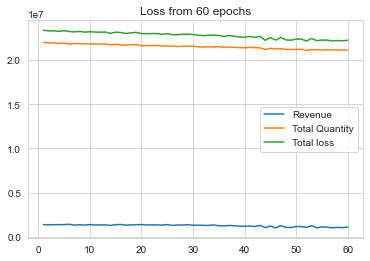

C:\Users\Chitra S. Lakhani\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning:

Using a target size (torch.Size([])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Validation Loss: 5959398399882.579
Time taken for training 70 epochs: 130.2812898159027


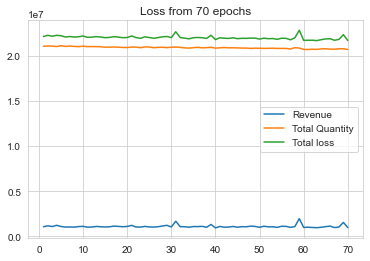

C:\Users\Chitra S. Lakhani\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning:

Using a target size (torch.Size([])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Validation Loss: 6016023113849.009
Time taken for training 80 epochs: 135.15381026268005


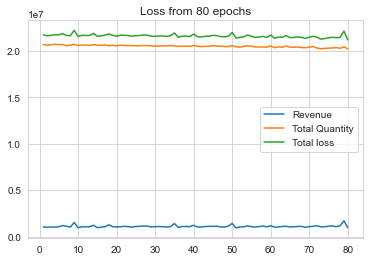

Validation Loss: 6515881492137.032


C:\Users\Chitra S. Lakhani\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning:

Using a target size (torch.Size([])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Time taken for training 90 epochs: 154.5202739238739


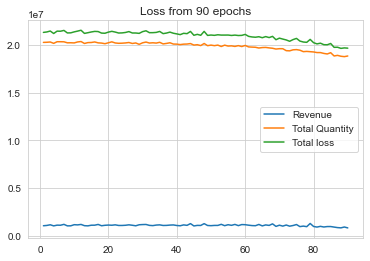

C:\Users\Chitra S. Lakhani\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning:

Using a target size (torch.Size([])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Validation Loss: 5639059479214.605
Time taken for training 100 epochs: 176.1739354133606


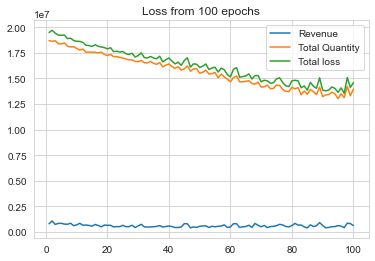

C:\Users\Chitra S. Lakhani\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning:

Using a target size (torch.Size([])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Validation Loss: 6158198591089.988
Time taken for training 110 epochs: 178.97116708755493


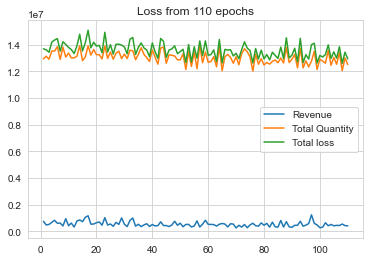

C:\Users\Chitra S. Lakhani\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning:

Using a target size (torch.Size([])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Validation Loss: 5630760524079.409
Time taken for training 120 epochs: 216.09138441085815


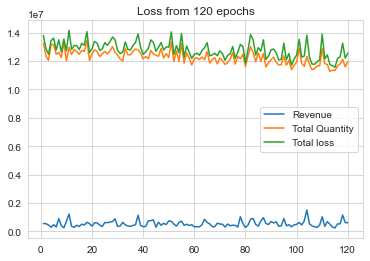

C:\Users\Chitra S. Lakhani\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning:

Using a target size (torch.Size([])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Validation Loss: 9936400093718.895
Time taken for training 130 epochs: 777.3366267681122


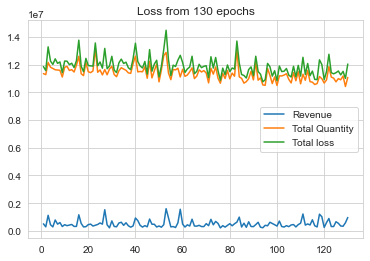

C:\Users\Chitra S. Lakhani\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning:

Using a target size (torch.Size([])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Validation Loss: 8967786426105.28
Time taken for training 140 epochs: 234.43686413764954


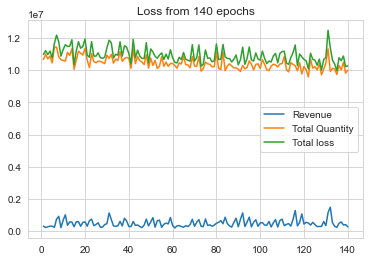

C:\Users\Chitra S. Lakhani\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning:

Using a target size (torch.Size([])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Validation Loss: 12024479112176.533
Time taken for training 150 epochs: 279.320827960968


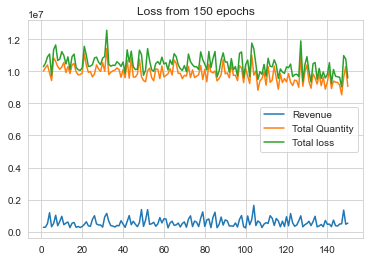

C:\Users\Chitra S. Lakhani\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning:

Using a target size (torch.Size([])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Validation Loss: 8346791604686.998
Time taken for training 160 epochs: 295.3737630844116


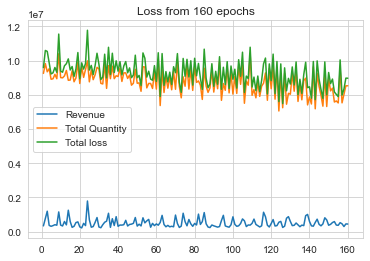

C:\Users\Chitra S. Lakhani\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning:

Using a target size (torch.Size([])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Validation Loss: 11178116599184.756
Time taken for training 170 epochs: 295.6976478099823


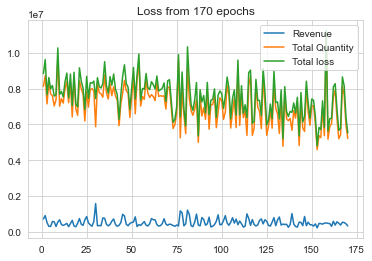

C:\Users\Chitra S. Lakhani\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning:

Using a target size (torch.Size([])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Validation Loss: 6879243794879.595
Time taken for training 180 epochs: 466.49698758125305


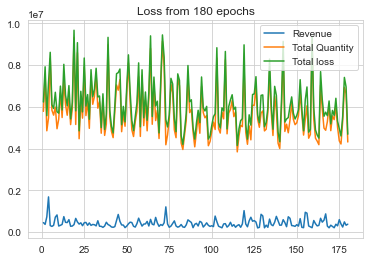

C:\Users\Chitra S. Lakhani\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning:

Using a target size (torch.Size([])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Validation Loss: 8019801478278.327
Time taken for training 190 epochs: 794.0941212177277


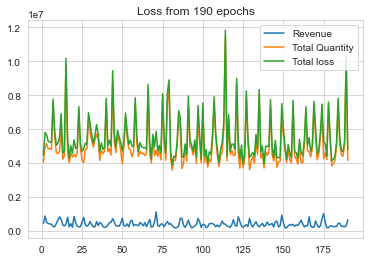

C:\Users\Chitra S. Lakhani\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning:

Using a target size (torch.Size([])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Validation Loss: 6505935022333.5
Time taken for training 200 epochs: 444.8599443435669


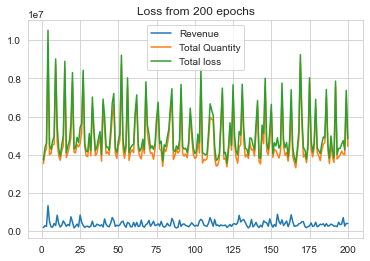

Validation Loss: 6789169460582.236
Total time taken to iterate through all the models: 4779.756052970886


C:\Users\Chitra S. Lakhani\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning:

Using a target size (torch.Size([])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time


data = pd.read_csv('wrangled_transactions.csv')

# Specify the input features (X) and target columns (Y) for each task
input_features = ['days_since_last_purchase', 'number_of_purchases', 'avg_order_cost']
target_columns = ['2010 revenue', '2010 Total Quantity']
# '2011 revenue', '2011 Total Quantity'

# Split the data into training and testing sets
X = data[['days_since_last_purchase',
       'number_of_purchases',
       'avg_order_cost'
       ]]
y = data[['2010 revenue','2010 Total Quantity',]]

X_train, X_temp, Y_train, Y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)
# Y_train = Y_train.to_numpy()
# Standardize input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define a multi-task regression model
class MultiTaskRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MultiTaskRegression, self).__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, 64).double(),
            nn.ReLU(),
            nn.Linear(64, 32).double(),
            nn.ReLU(),
            nn.Linear(32, 16).double(),
            nn.ReLU(),
            nn.Linear(16, 8).double(),
            nn.ReLU()
        )
        self.task_specific_layers = nn.ModuleList([
            nn.Sequential(nn.Linear(8, 4).double(), nn.ReLU(), nn.Linear(4, output_dim).double()) for _ in range(len(target_columns))
        ])

    def forward(self, x, task_idx):
        shared_output = self.shared_layers(x)
        task_output = self.task_specific_layers[task_idx](shared_output)
        return task_output

# Create the model and set hyperparameters
input_dim = len(input_features)
output_dim = 2  
model = MultiTaskRegression(input_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
strt_time1 = time.time()
# Training loop
total_loss_iter = []
for num_epochs in range(50, 201, 10):
    task1 = []
    task2 = []
    total = []
    strt_time2 = time.time()
    for epoch in range(num_epochs):
        total_loss_task1 = 0
        total_loss_task2 = 0

        for task_idx in range(len(target_columns)):
            total_loss = 0
            for i in range(X_train.shape[0]):
                x = torch.tensor(X_train[i], dtype=torch.float64)
                y = torch.tensor(Y_train.iloc[i, task_idx], dtype=torch.float64)

                optimizer.zero_grad()
                outputs = model(x, task_idx)
                loss = criterion(outputs, y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            if task_idx == 0:
                total_loss_task1 += total_loss
            else:
                total_loss_task2 += total_loss
    #     print(f'Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss}')

        total.append((total_loss_task1 + total_loss_task2))
        task1.append((total_loss_task1))
        task2.append((total_loss_task2))
    end_time2 = time.time()
    
    print(f'Time taken for training {num_epochs} epochs: {end_time2-strt_time2}')
#     yarr = np.array([[task1],[task2],[total]])
    xarr = np.arange(1,num_epochs+1)
    plt.plot(xarr, task1, label = "Revenue") 
    plt.plot(xarr, task2, label = "Total Quantity") 
    plt.plot(xarr, total, label = "Total loss")
    plt.title(f'Loss from {num_epochs} epochs')
    plt.legend() 
    plt.show()
    
    total_sum = np.sum(total)
    total_loss_iter.append(total_sum)
    
    # Testing the model
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for task_idx in range(len(target_columns)):
            for i in range(X_val.shape[0]):
                x = torch.tensor(X_val.iloc[i, :].values, dtype=torch.float64)
                y = torch.tensor(Y_val.iloc[i, task_idx], dtype=torch.float64)
                outputs = model(x, task_idx)
                loss = criterion(outputs, y)
                test_loss += loss.item()

        print(f'Validation Loss: {test_loss}')
print(f'Total time taken to iterate through all the models: {time.time() - strt_time1}')
# loss = criterion(outputs, y)
# print(loss)

# You can use the trained model to make predictions for each task on new invoice data

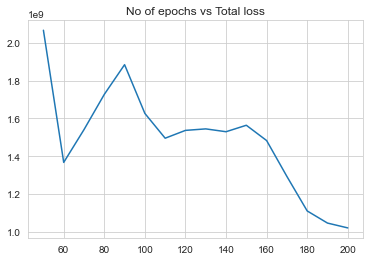

In [45]:
x = np.arange(50,201,10)
plt.plot(x, total_loss_iter)
plt.title('No of epochs vs Total loss')
plt.show()

In [ ]:
print(model.eval())

In [47]:
input_features = ['days_since_last_purchase', 'number_of_purchases', 'avg_order_cost']
target_columns = ['revenue sum', 'Quantity sum']
Test_x = Z[['days_since min','days_since nunique', 'avg_order_cost']]
Test_y = Z[['revenue sum', 'Quantity sum']]

pred1 = []
pred2 = []

model.eval()
with torch.no_grad():
    test_loss = 0
    
    for task_idx in range(len(target_columns)):
        task_outputs = []
        for i in range(X_test.shape[0]):
            x = torch.tensor(X_test[i, :], dtype=torch.float64)
            y = torch.tensor(Y_test.iloc[i, task_idx], dtype=torch.float64)
            outputs = model(x, task_idx)
            loss = criterion(outputs, y)
            test_loss += loss.item()
            
            task_outputs.append(outputs.mean().item())
        if task_idx == 0:
            pred1 = task_outputs
        else:
            pred2 = task_outputs
    print(f'Test Loss: {test_loss}')



Test Loss: 1539963.1828354457


C:\Users\Chitra S. Lakhani\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning:

Using a target size (torch.Size([])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



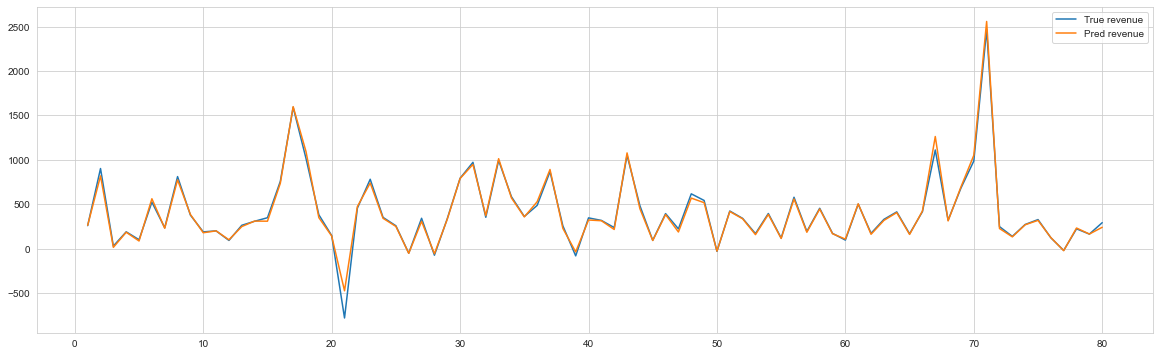

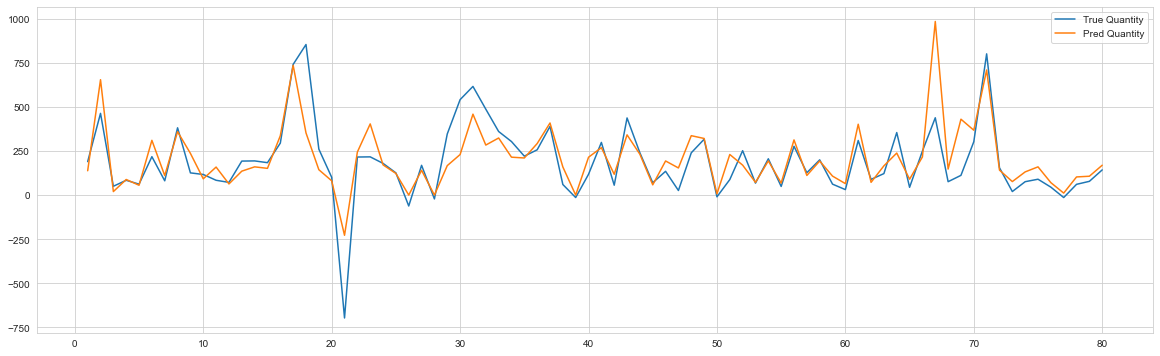

In [49]:
from sklearn.metrics import confusion_matrix
x = np.arange(1,X_test.shape[0]+1)

plt.figure(figsize=(20,6))
plt.plot(x,Y_test.iloc[:, 0], label = 'True revenue')
plt.plot(x,pred1, label = 'Pred revenue')
plt.legend()
plt.show()

plt.figure(figsize=(20,6))
plt.plot(x,Y_test.iloc[:, 1], label = 'True Quantity')
plt.plot(x,pred2, label = 'Pred Quantity')
plt.legend()
plt.show()

In [51]:
from sklearn.metrics import r2_score
score = r2_score(Y_test.iloc[:, 0], pred1)
print("The accuracy of our model is {}%".format(round(score, 2) *100))
score = r2_score(Y_test.iloc[:, 1], pred2)
print("The accuracy of our model is {}%".format(round(score, 2) *100))

The accuracy of our model is 99.0%
The accuracy of our model is 60.0%


In [52]:
from sklearn.metrics import mean_absolute_error
score = mean_absolute_error(Y_test.iloc[:, 0], pred1)
print("The Mean Absolute Error of our Model is {}".format(round(score, 2)))
score = mean_absolute_error(Y_test.iloc[:, 1], pred2)
print("The Mean Absolute Error of our Model is {}".format(round(score, 2)))

The Mean Absolute Error of our Model is 23.64
The Mean Absolute Error of our Model is 77.74


In [53]:
from sklearn.metrics import mean_squared_error
import numpy as np
score = np.sqrt(mean_absolute_error(Y_test.iloc[:, 0], pred1))
print("The Mean Absolute Error of our Model is {}".format(round(score, 2)))
score = np.sqrt(mean_absolute_error(Y_test.iloc[:, 1], pred2))
print("The Mean Absolute Error of our Model is {}".format(round(score, 2)))

The Mean Absolute Error of our Model is 4.86
The Mean Absolute Error of our Model is 8.82
